In [1]:
import sys
print(sys.executable)

import numpy as np # linear algebra
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import cv2


import import_ipynb

from CustomDataset import ControlsDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('using device', device)
torch.cuda.empty_cache()

C:\Users\Michael\anaconda3\envs\pytorch\python.exe
importing Jupyter notebook from CustomDataset.ipynb
using device cuda


In [2]:
dataset = ControlsDataset(img_folder = '../data/cropped_reduced/',
                          csv_path='../data/cropped_reduced/data.csv',
                          stack_size = 3,
                         batch_size = 128)

Total training stacks 52
Total validation stacks 35


In [3]:
class Autoencoder(nn.Module):
    
        
    def set_encoding(self,flag):
        self.encoding = flag

    def set_decoding(self,flag):
        self.decoding = flag
            
    
    def __init__(self):
        super(Autoencoder,self).__init__()
        img_size = torch.Size([1, 1, 100, 200]) # [batch_size, channels, height, width]
        empty = torch.zeros(img_size)
        
        channels = [1,8,16,32,64]
        kernels = [5,5,5,5]
        strides = [2,2,2,2]
        paddings = [0,0,0,0]
        dilations = [1,1,1,1]
        output_paddings = [(1,1),(1,1),(1,0),(0,1)]
        encoding_activations = [nn.ReLU(True),nn.ReLU(True),nn.ReLU(True),nn.ReLU(True)]
        decoding_activations = [nn.Sigmoid(),nn.ReLU(True),nn.ReLU(True),nn.ReLU(True)]
        emb_space = 10
        
        self.encoder_modules = []
        for i in range(len(kernels)):
            convolution = nn.Conv2d(channels[i], channels[i+1], 
                                    kernels[i],strides[i],paddings[i],dilations[i])
            self.encoder_modules.append(convolution)
            self.encoder_modules.append(encoding_activations[i])
            
        self.encoder = nn.Sequential(*self.encoder_modules)
        
        units = self.encoder(empty).numel()
        print(units)
        
        self.emb1 = nn.Sequential(nn.Linear(units, emb_space))
        self.emb2 = nn.Sequential(nn.Linear(emb_space, units))
        
        print(units*emb_space)
        
        
        self.decoder_modules = []
        for i in range(len(kernels)-1,-1,-1):
            convolution = nn.ConvTranspose2d(channels[i+1], channels[i], 
                                    kernels[i],strides[i],paddings[i],output_paddings[i],
                                    dilation = dilations[i])
            self.decoder_modules.append(convolution)
            self.decoder_modules.append(decoding_activations[i])
            
        self.decoder = nn.Sequential(*self.decoder_modules)
        
        self.set_encoding(True)
        self.set_decoding(True)
        
        
    def forward(self,x):
        batch_size = x.shape[0]
        if self.encoding:
            x = self.encoder(x)
            self.pre_emb = x.shape[1:]
            x = x.reshape((batch_size,-1))
            x = self.emb1(x)
        if self.decoding:
            x = self.emb2(x)
            x = x.reshape(list([batch_size]) + list(self.pre_emb))
            x = self.decoder(x)
        return x
    
    
    def shapes(self, w, h):
        for element in self.encoder_modules:
            print(element)
        wc1 = self.convolve(w,5,stride=2)
        wc2 = self.convolve(wc1,5,stride=2)
        wc3 = self.convolve(wc2,5,stride=2)
        wc4 = self.convolve(wc3,5,stride=2)
        
        hc1 = self.convolve(w,5,stride=2)
        hc2 = self.convolve(wc1,5,stride=2)
        hc3 = self.convolve(wc2,5,stride=2)
        hc4 = self.convolve(wc3,5,stride=2)
        
        
    def convolve(self,dim,kernel,padding=0,stride=1,dilation=1):
        spacing = (kernel-1)*(dilation-1)
        return (dim + 2*padding - kernel - spacing)/stride + 1
    
    def deconvolve(self,dim,kernel,padding=0,stride=1,dilation=1):
        spacing = (kernel-1)*(dilation-1)
        return s*(n-1) + f + spacing - 2*padding
        
        
    def test(self):
        wc1 = int((w - 5)/2 + 1)
        wc2 = int((wc1 - 5)/2 + 1)
        wc3 = int((wc2 - 5)/2 + 1)
        wc4 = int((wc3 - 5)/2 + 1)
        
        hc1 = int((h - 5)/2 + 1)
        hc2 = int((hc1 - 5)/2 + 1)
        hc3 = int((hc2 - 5)/2 + 1)
        hc4 = int((hc3 - 5)/2 + 1)
        
        print(w,h)
        print(wc1,hc1)
        print(wc2,hc2)
        print(wc3,hc3)
        print(wc4,hc4)
        
        opad3 = (0,1)
        opad2 = (1,0)
        opad1 = (1,1)
        opad0 = (1,1)
        
        wc3 = 2*(wc4-1)+5 + opad3[0]
        wc2 = 2*(wc3-1)+5 + opad2[0]
        wc1 = 2*(wc2-1)+5 + opad1[0]
        w = 2*(wc1-1)+5 +  opad0[0]
        
        
        hc3 = 2*(hc4-1)+5 + opad3[1]
        hc2 = 2*(hc3-1)+5 + opad2[1]
        hc1 = 2*(hc2-1)+5 + opad1[1]
        h = 2*(hc1-1)+5 +  opad0[1]
        
        print(wc4,hc4)
        print(wc3,hc3)
        print(wc2,hc2)
        print(wc1,hc1)
        print(w,h)
        

In [4]:
num_epochs = 10 #you can go for more epochs, I am using a mac
batch_size = 128

In [5]:
model = Autoencoder()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

1728
17280


In [6]:
writer = SummaryWriter()

def color_reducer(img_stack):
    image = img_stack.transpose((1,2,0))
    vectorized = image.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)


    K = 6
    attempts=10
    ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    
    center = np.uint8(center*255)
    res = center[label.flatten()]
    reduced_image = res.reshape((image.shape))
    return reduced_image

def processImg(img):
    #expects image with values [0..255]
    orgImg = np.uint8(img)
    # Applying Canny
    img = cv2.Canny(orgImg, 
                    threshold1=50, 
                    threshold2=200,
                    apertureSize=3) 
    # Applying HoughLines
    lines = cv2.HoughLinesP(image = img,
                            lines = 1,
                            rho = 1,
                            theta = np.pi/180,
                            threshold = 40,
                            minLineLength=30,
                            maxLineGap=10)
    #plotting the lines
    for line in lines:
        x1,y1,x2,y2 = line[0]
        plt.plot((x1,x2),(y1,y2), '-k')
        
    #plot the image
    plt.imshow(orgImg, interpolation='nearest')


In [7]:
from tqdm.notebook import tqdm_notebook
model.set_encoding(True)
model.set_decoding(True)
try:
    model.load_state_dict(torch.load("autoencoder.pt"))
except:
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        print(len(dataset.dataloader))
        for count,data in tqdm_notebook(enumerate(dataset.dataloader),
                                 total=len(dataset.dataloader)):
            img = data['image'].float()
            """
            reduced_images = torch.empty(img.shape, dtype=torch.float32)
            for i,img_stack in enumerate(img.numpy()):
                reduced = color_reducer(img_stack)
                reduced_images[i] = torch.from_numpy(reduced.transpose(2,0,1)/255)
                #plt.imshow(np.transpose(reduced_images[i].numpy(),(1,2,0)), cmap = "gray")
                #plt.show()

            img = reduced_images
            """
            for i in range(img.shape[1]):
                single = img[:,i,::]
                single = single.unsqueeze(1)

                single = torch.Tensor(single)
                # ===================forward=====================
                output = model(single)
                output = output
                loss = distance(output, single)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += float(loss)
            # ===================log========================
        writer.add_scalar('myscalar', total_loss/count, epoch)
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))
        image =  np.transpose(single[0].detach().numpy(),(1,2,0)).squeeze()
        #plt.imshow(image/2+0.5, cmap = "gray")
        plt.imshow(image, cmap = "gray")
        plt.show()
        image =  np.transpose(output[0].detach().numpy(),(1,2,0)).squeeze()
        plt.imshow(image, cmap = "gray")
        plt.show()
    

torch.Size([128, 3, 100, 200])


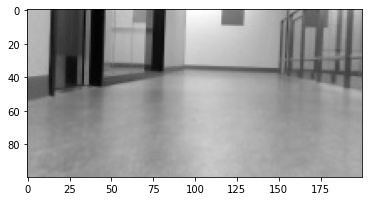

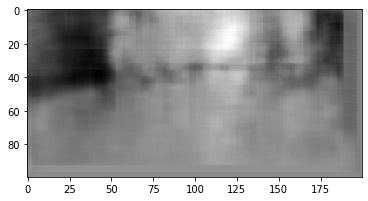

torch.Size([128, 3, 100, 200])


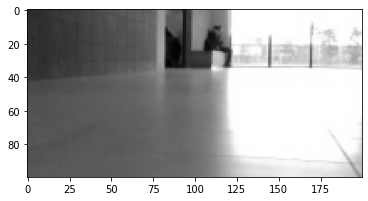

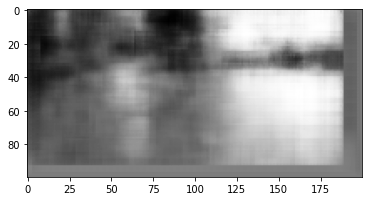

torch.Size([128, 3, 100, 200])


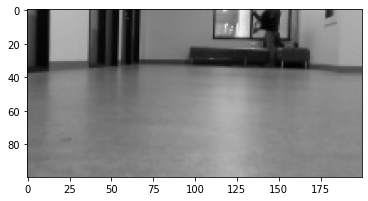

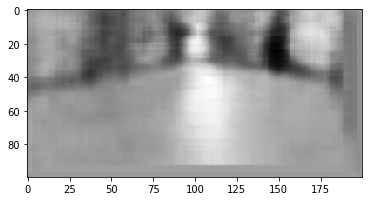

torch.Size([128, 3, 100, 200])


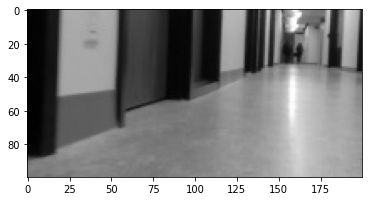

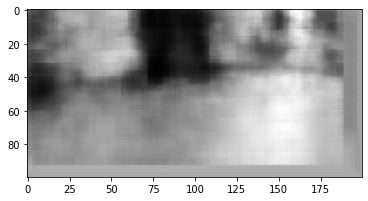

torch.Size([128, 3, 100, 200])


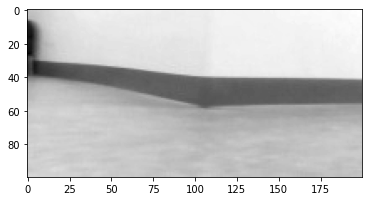

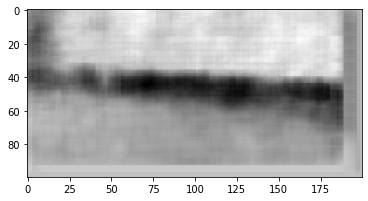

torch.Size([128, 3, 100, 200])


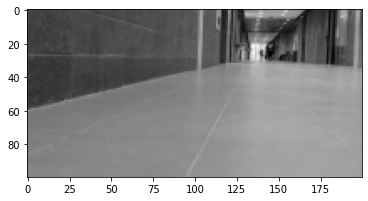

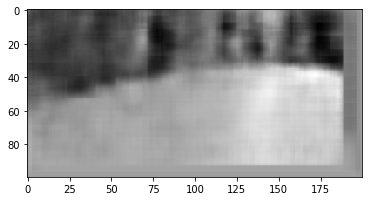

torch.Size([128, 3, 100, 200])


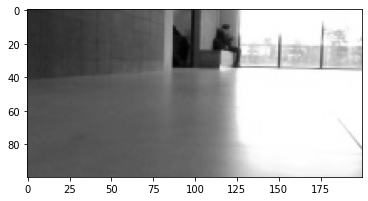

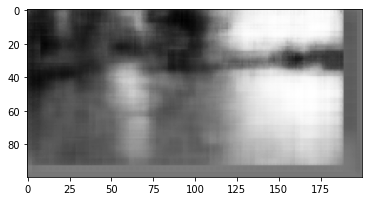

torch.Size([128, 3, 100, 200])


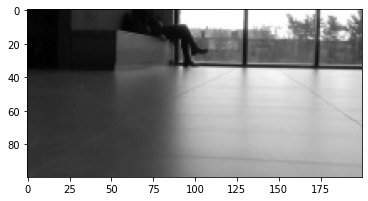

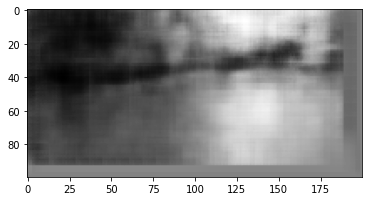

torch.Size([128, 3, 100, 200])


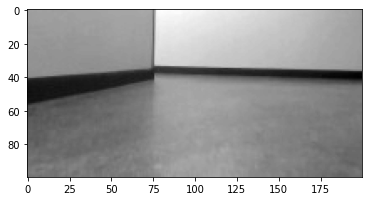

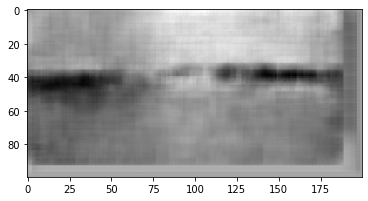

torch.Size([128, 3, 100, 200])


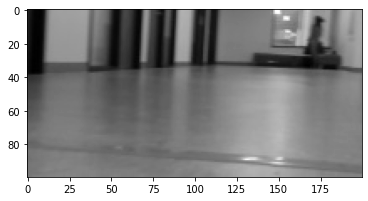

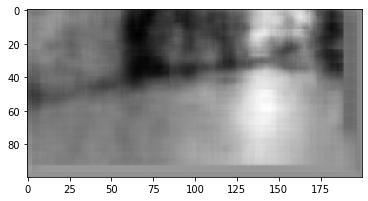

torch.Size([128, 3, 100, 200])


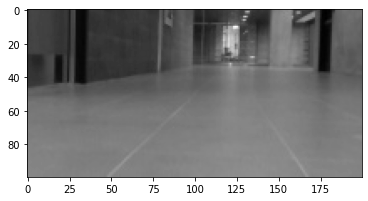

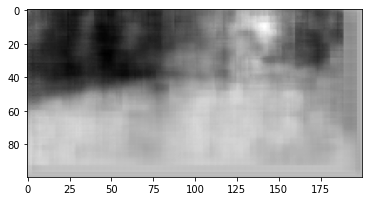

torch.Size([128, 3, 100, 200])


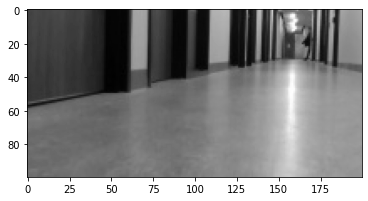

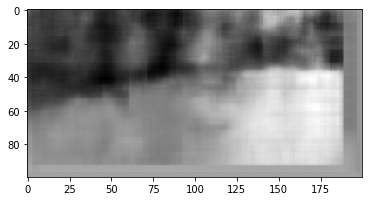

torch.Size([128, 3, 100, 200])


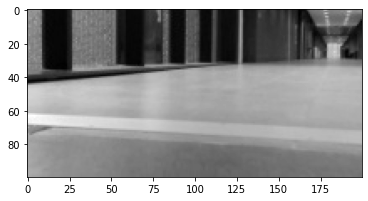

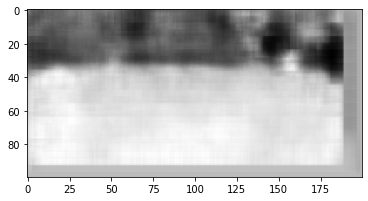

torch.Size([128, 3, 100, 200])


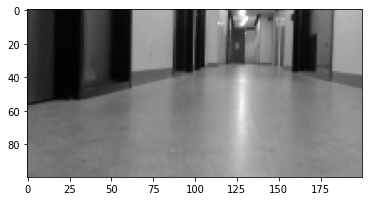

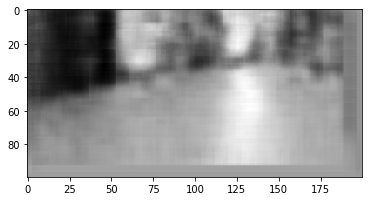

torch.Size([128, 3, 100, 200])


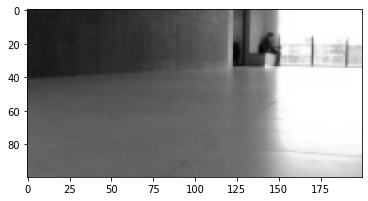

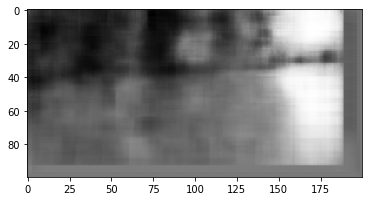

torch.Size([128, 3, 100, 200])


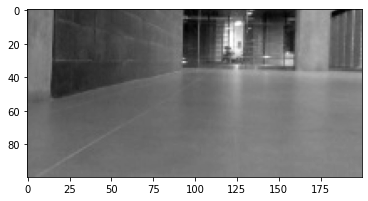

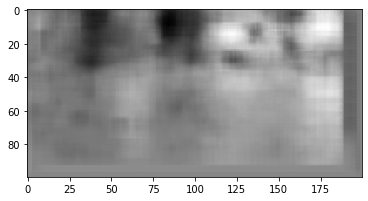

torch.Size([128, 3, 100, 200])


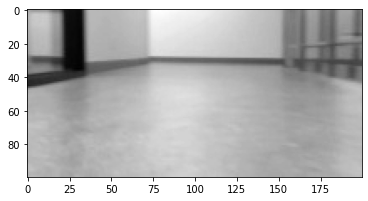

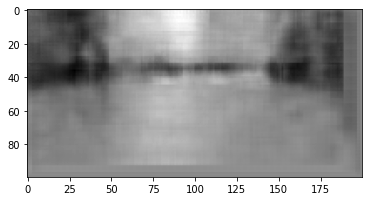

torch.Size([128, 3, 100, 200])


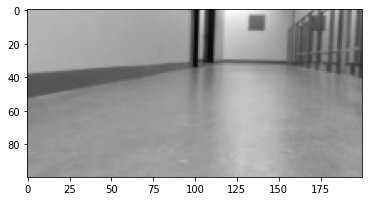

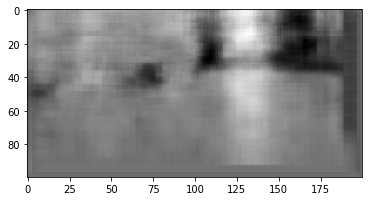

torch.Size([128, 3, 100, 200])


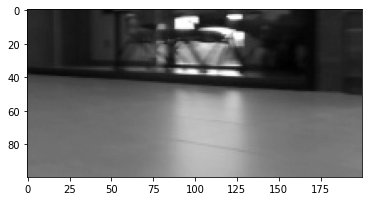

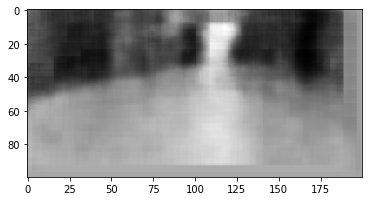

torch.Size([128, 3, 100, 200])


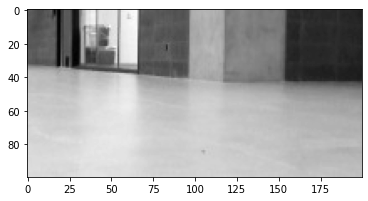

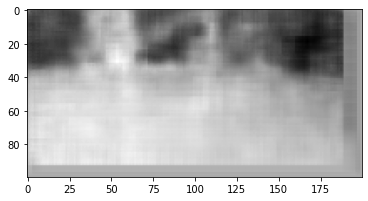

torch.Size([128, 3, 100, 200])


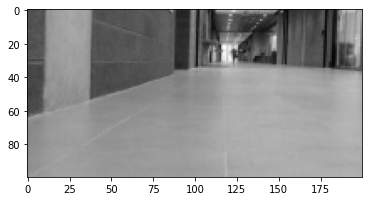

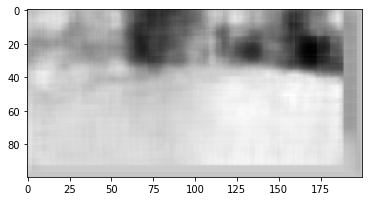

torch.Size([128, 3, 100, 200])


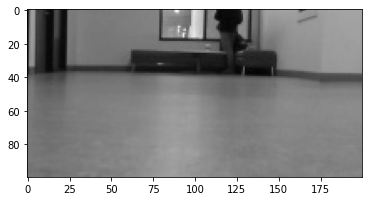

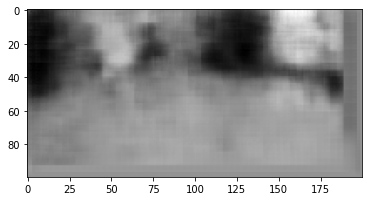

torch.Size([128, 3, 100, 200])


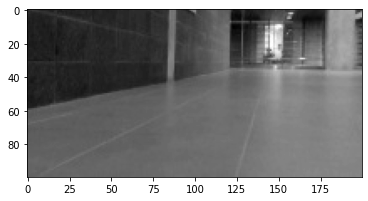

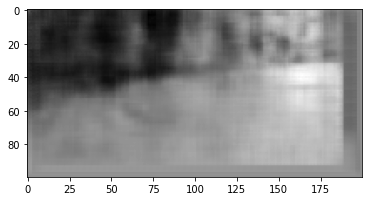

torch.Size([128, 3, 100, 200])


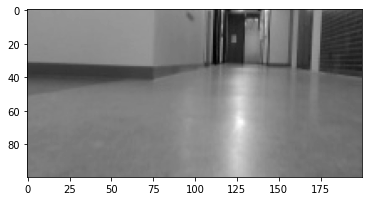

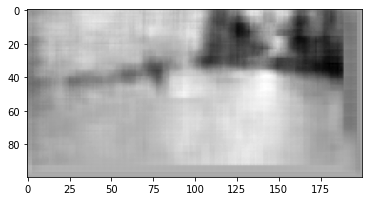

torch.Size([128, 3, 100, 200])


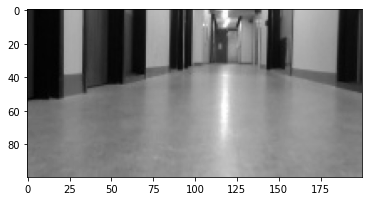

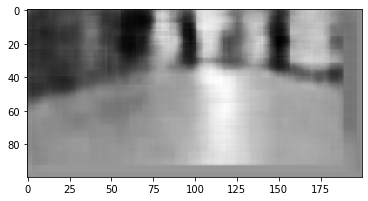

torch.Size([128, 3, 100, 200])


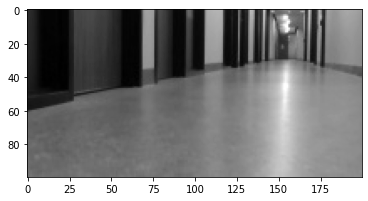

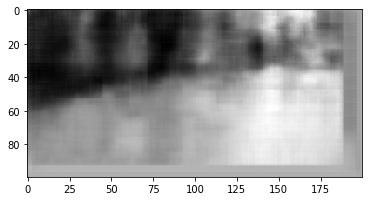

torch.Size([128, 3, 100, 200])


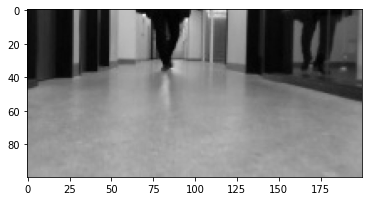

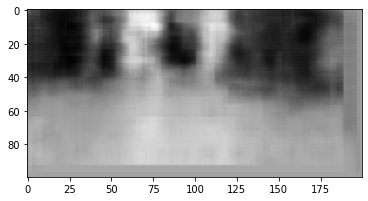

torch.Size([128, 3, 100, 200])


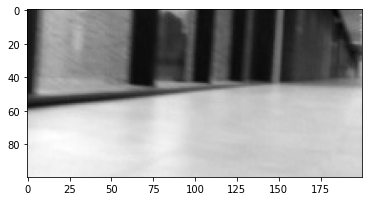

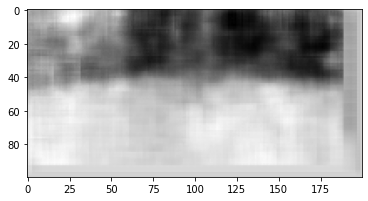

torch.Size([128, 3, 100, 200])


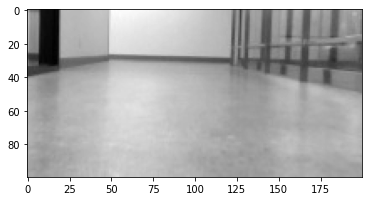

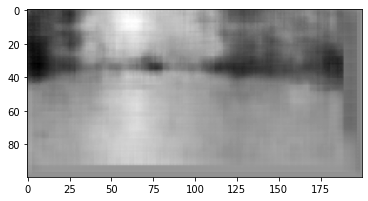

torch.Size([128, 3, 100, 200])


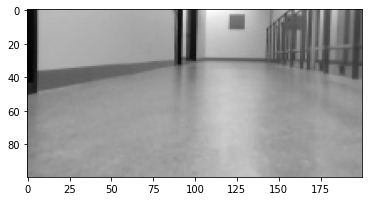

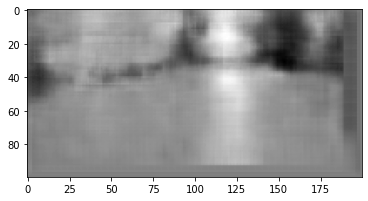

torch.Size([128, 3, 100, 200])


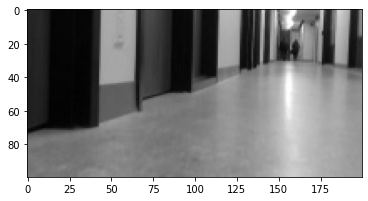

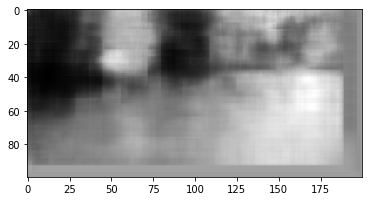

torch.Size([128, 3, 100, 200])


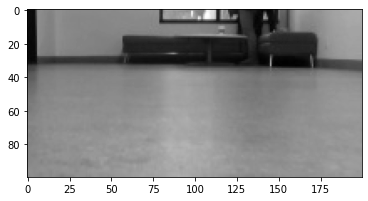

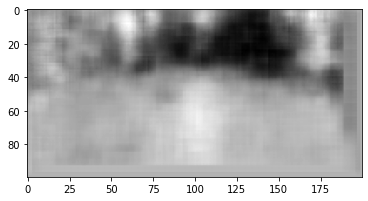

torch.Size([128, 3, 100, 200])


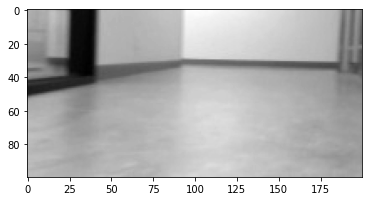

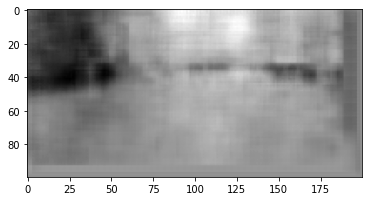

torch.Size([128, 3, 100, 200])


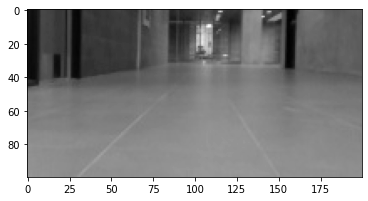

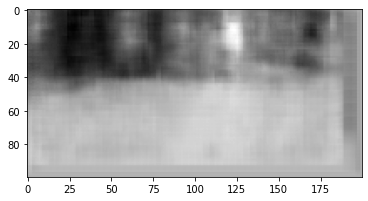

torch.Size([54, 3, 100, 200])


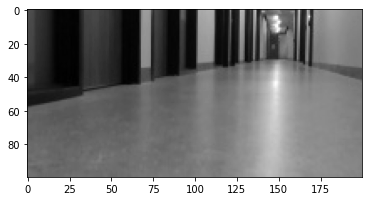

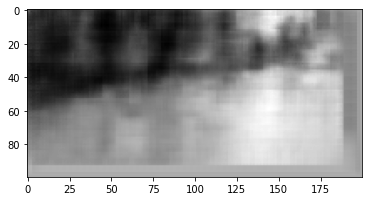

In [8]:
model.eval()
model.set_encoding(True)
model.set_decoding(True)
import numpy as np
for epoch in range(num_epochs):
    for data in dataset.validloader:
        img = data['image'].float()
        print(img.shape)
        for i in range(img.shape[1]):
            single = img[:,i,::]
            single = single.unsqueeze(1)
            
            single = torch.Tensor(single)
            output = model(single)

            image =  np.transpose(single[0].detach().numpy(),(1,2,0)).squeeze()
            plt.imshow(image, cmap = "gray")
            plt.show()
            image =  np.transpose(output[0].detach().numpy(),(1,2,0)).squeeze()
            plt.imshow(image, cmap = "gray")
            plt.show()
            break
    break
        

In [9]:
torch.save(model.state_dict(), "autoencoder.pt")

In [10]:
model.set_encoding(True)
model.set_decoding(False)
print(img.shape)
single = img[:,0,::]
single = single.unsqueeze(1)
single = torch.Tensor(single)
encoded = model(single)
print(single.shape)

torch.Size([54, 3, 100, 200])
torch.Size([54, 1, 100, 200])


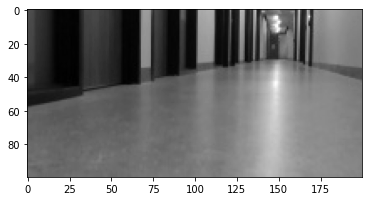

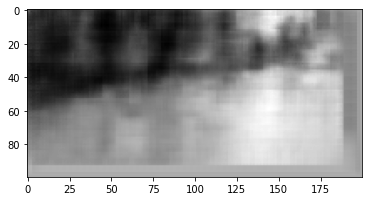

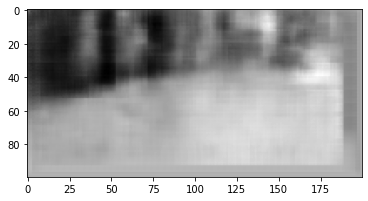

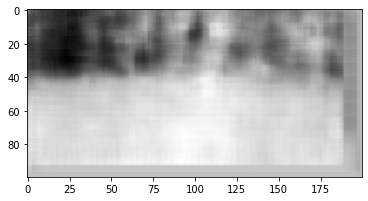

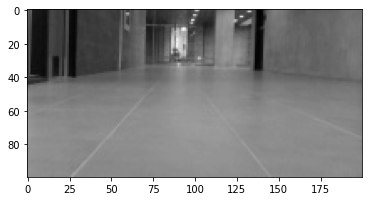

In [11]:
model.set_encoding(False)
model.set_decoding(True)
first = encoded[0]
second = encoded[9]

decoded = model(encoded)
merge = torch.unsqueeze((first+second)/2, 0)
dec_mid = model(merge).squeeze(0)

image =  np.transpose(single[0],(1,2,0)).squeeze()
plt.imshow(image, cmap = "gray")
plt.show()
image =  decoded[0].detach().numpy().squeeze()
plt.imshow(image, cmap = "gray")
plt.show()
image =  np.transpose(dec_mid.detach().numpy(),(1,2,0)).squeeze()
plt.imshow(image, cmap = "gray")
plt.show()
image =  np.transpose(decoded[9].detach().numpy(),(1,2,0)).squeeze()
plt.imshow(image, cmap = "gray")
plt.show()
image =  np.transpose(single[9],(1,2,0)).squeeze()
plt.imshow(image, cmap = "gray")
plt.show()

In [12]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.decoder_rnn = nn.GRU(input_size=emb_size, #DONE
                                  hidden_size=hidden_size, #DONE
                                  batch_first=True)
        
        self.proj = nn.Linear(in_features=hidden_size, # DONE
                              out_features=1) # DONE
        self.activation = nn.Sigmoid()
        
    def forward(self, inp):
        decoded = self.decoder_rnn(inp)
        one_output = self.proj(decoded[0])
        one_output = self.activation(one_output[-1])
        return one_output

In [29]:
predictor = RNN(10, 10)
in_tensor = merge.unsqueeze(0)
tensors = torch.cat((in_tensor, in_tensor), 0)                          
print(tensors.shape)
out_tensor = predictor(tensors)
print(out_tensor)

torch.Size([2, 1, 10])
tensor([[0.4849]], grad_fn=<SigmoidBackward>)


In [30]:
model.set_encoding(True)
model.set_decoding(False)
lst = []
for i in range(img.shape[1]):
    single = img[:,i,::]
    single = single.unsqueeze(1)
    single = torch.Tensor(single)
    encoded = model(single).unsqueeze(1)
    lst.append(encoded)
    print(encoded.shape)


rnn_input = torch.cat(lst, 1) 
reshaped_input = torch.transpose(rnn_input, 1,0)
print(reshaped_input.shape)

torch.Size([128, 1, 10])
torch.Size([128, 1, 10])
torch.Size([128, 1, 10])
torch.Size([3, 128, 10])


In [31]:
out_tensor = predictor(reshaped_input)
print(out_tensor[0][-1].shape)
print(out_tensor[0][-1])

torch.Size([])
tensor(0.6414, grad_fn=<SelectBackward>)


In [120]:
predictor.train()
num_epochs = 10

distance = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(),weight_decay=1e-5)
for epoch in range(num_epochs):
    total_loss = 0
    print(len(dataset.dataloader))
    for count,data in tqdm_notebook(enumerate(dataset.dataloader),
                             total=len(dataset.dataloader)):
        img = data['image'].float()
        labels = data['control'].float()
        lst = []
        for i in range(img.shape[1]):
            single = img[:,i,::]
            single = single.unsqueeze(1)
            single = torch.Tensor(single)
            encoded = model(single).unsqueeze(1)
            lst.append(encoded)
        
        # ===================forward=====================
        rnn_input = torch.cat(lst, 1) 
        reshaped_input = torch.transpose(rnn_input, 1,0)
        out_tensor = predictor(reshaped_input)
        # ===================backward====================
        loss = distance(out_tensor, labels)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += float(loss)
        # ===================log========================
    writer.add_scalar('rnnscalar', total_loss/count, epoch)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss/count))

52



epoch [1/10], loss:0.0430
52



epoch [2/10], loss:0.0427
52



epoch [3/10], loss:0.0430
52



epoch [4/10], loss:0.0428
52



epoch [5/10], loss:0.0429
52



epoch [6/10], loss:0.0425
52



epoch [7/10], loss:0.0421
52



epoch [8/10], loss:0.0423
52



epoch [9/10], loss:0.0421
52



epoch [10/10], loss:0.0425


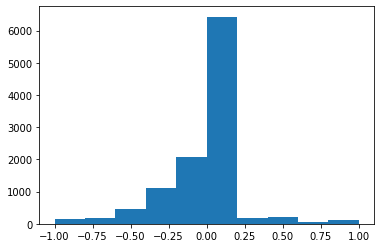

In [125]:
histogram = plt.hist(dataset.labels.dataframe["Angle"], bins = 10)

In [126]:
def find_category(numbers):
    buckets = histogram[1]
    lst = []
    for number in numbers:
        for i in range(len(buckets)-1):
            if number >= buckets[i] and number <= buckets[i+1]:
                lst.append(i)
                break
    return lst

In [127]:
find_category([1])

[9]

In [131]:
model.eval()
predictor.eval()
model.set_encoding(True)
model.set_decoding(False)
import numpy as np
for epoch in range(num_epochs):
    for data in dataset.dataloader:
        img = data['image'].float()
        labels = data['control'].float()
        
        lst = []
        for i in range(img.shape[1]):
            single = img[:,i,::]
            single = single.unsqueeze(1)
            single = torch.Tensor(single)
            encoded = model(single).unsqueeze(1)
            lst.append(encoded)
        
        # ===================forward=====================
        rnn_input = torch.cat(lst, 1) 
        reshaped_input = torch.transpose(rnn_input, 1,0)
        out_tensor = predictor(reshaped_input)
        output = out_tensor[0][-1]
        print(out_tensor.shape)
        #print(find_category(out_tensor))
        #print(find_category(labels))
        print("labels")
        print(find_category(labels.squeeze()))
        print("predictions")
        print(find_category(out_tensor.squeeze()))
        
        """
        for i in range(img.shape[1]):
            single = img[:,i,::]
            single = single.unsqueeze(1)
            
            single = torch.Tensor(single)
            output = model(single)

            image =  np.transpose(single[0].detach().numpy(),(1,2,0)).squeeze()
            plt.imshow(image, cmap = "gray")
            plt.show()
            image =  np.transpose(output[0].detach().numpy(),(1,2,0)).squeeze()
            plt.imshow(image, cmap = "gray")
            plt.show()
            break
        """
    break
        

torch.Size([128, 1])
labels
[6, 4, 3, 4, 4, 4, 4, 5, 5, 4, 3, 4, 4, 4, 2, 7, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 5, 4, 5, 5, 3, 4, 3, 7, 4, 4, 5, 4, 4, 4, 5, 3, 5, 3, 9, 5, 4, 8, 1, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3, 4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
predictions
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
torch.Size([128, 1])
labels
[3, 4, 1, 4, 5, 3, 4, 4, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 7, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 4,

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "autoencoder.pt")